# Unsupervised Learning Final Project: Iris Species Clustering Analysis
## Comparative Study of K-Means vs Agglomerative Hierarchical Clustering

A copy of this notebook can be found on [GitHub](git@github.com:Farzat07/Unsupervised-Learning-Final-Project-Iris-Species-Clustering-Analysis.git)

## Problem Description

### Background
The Iris flower dataset is a classic multivariate dataset introduced by Sir Ronald Fisher in 1936. It consists of 150 samples from three species of Iris flowers (Iris setosa, Iris versicolor, and Iris virginica) with four features measured from each sample: sepal length, sepal width, petal length, and petal width.

This is perhaps the best known database to be found in the pattern recognition literature. Fisher’s paper is a classic in the field and is referenced frequently to this day. While one class is linearly separable from the other 2, the latter are NOT linearly separable from each other, making the problem interesting.

### Objectives
This project aims to:
- Apply and compare two fundamental clustering algorithms: K-Means and Agglomerative Hierarchical Clustering
- Evaluate clustering performance using both internal (silhouette score) and external (accuracy, ARI) metrics
- Determine optimal number of clusters using multiple validation techniques

### Import Necessary Libraries

In [1]:
from itertools import permutations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, accuracy_score, confusion_matrix
import scipy.cluster.hierarchy as sch
from scipy import stats

%matplotlib inline

### Load and Explore the Dataset

Dataset Overview:
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Species: ['setosa', 'versicolor', 'virginica']

Dataframe structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    object 
 5   true_labels        150 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,true_labels
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0


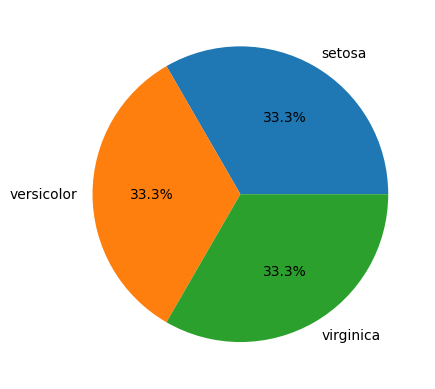

In [2]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
target = iris.target
species_names = iris.target_names

# Create a DataFrame for better visualization
df = pd.DataFrame(X, columns=iris.feature_names)
df['species'] = species_names[target]
df['true_labels'] = target

print("Dataset Overview:")
print("Features:", iris.feature_names)
print("Species:", species_names.tolist())
print("\nDataframe structure:")
df.info()
df.species.value_counts().plot.pie(autopct='%.1f%%', ylabel='')
df.head()

### EDA (Exploratory Data Analysis)

In [3]:
# Basic statistics
df[iris.feature_names].describe().round(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.00,150.00,150.00,150.00
mean,5.84,3.06,3.76,1.20
std,0.83,0.44,1.77,0.76
min,4.30,2.00,1.00,0.10
25%,5.10,2.80,1.60,0.30
50%,5.80,3.00,4.35,1.30
75%,6.40,3.30,5.10,1.80
max,7.90,4.40,6.90,2.50


In [4]:
# Check for missing values
print("MISSING VALUES:")
print("=" * 30)
print(df.isnull().sum())

MISSING VALUES:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
true_labels          0
dtype: int64


### Statistical Analysis by Species

In [5]:
# Statistics by species
print("STATISTICS BY SPECIES:")
print("=" * 50)
species_stats = df.groupby('species')[iris.feature_names].agg(['mean', 'std', 'min', 'max']).round(2)
print(species_stats)

STATISTICS BY SPECIES:
           sepal length (cm)                 sepal width (cm)                  \
                        mean   std  min  max             mean   std  min  max   
species                                                                         
setosa                  5.01  0.35  4.3  5.8             3.43  0.38  2.3  4.4   
versicolor              5.94  0.52  4.9  7.0             2.77  0.31  2.0  3.4   
virginica               6.59  0.64  4.9  7.9             2.97  0.32  2.2  3.8   

           petal length (cm)                 petal width (cm)                  
                        mean   std  min  max             mean   std  min  max  
species                                                                        
setosa                  1.46  0.17  1.0  1.9             0.25  0.11  0.1  0.6  
versicolor              4.26  0.47  3.0  5.1             1.33  0.20  1.0  1.8  
virginica               5.55  0.55  4.5  6.9             2.03  0.27  1.4  2.5  


### Visual EDA

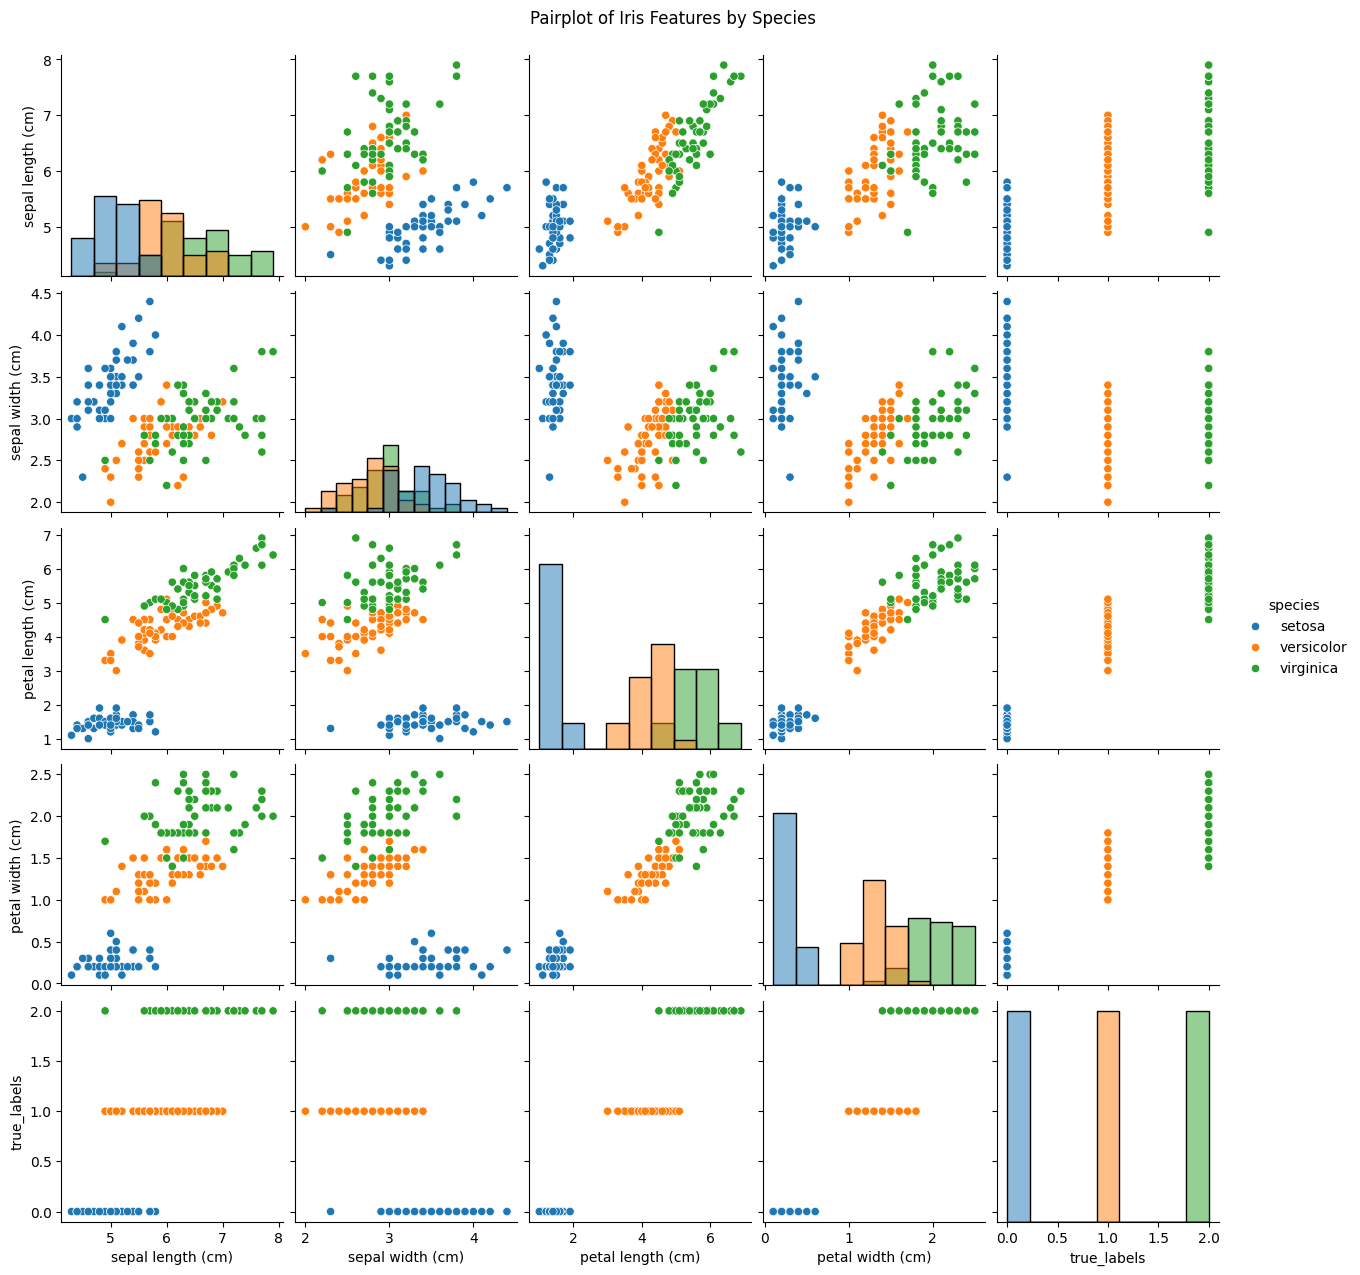

In [6]:
# Pairplot to see relationships between features
sns.pairplot(df, hue='species', diag_kind='hist')
plt.suptitle('Pairplot of Iris Features by Species', y=1.02)
plt.show()

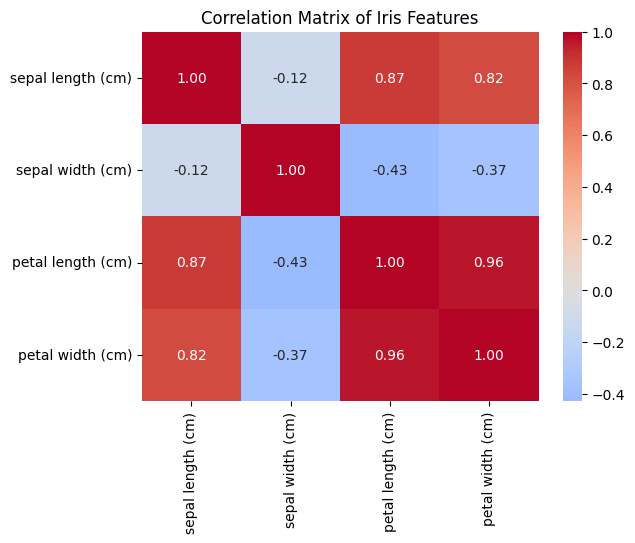

In [7]:
# Correlation matrix
correlation_matrix = df[iris.feature_names].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Iris Features')
plt.show()

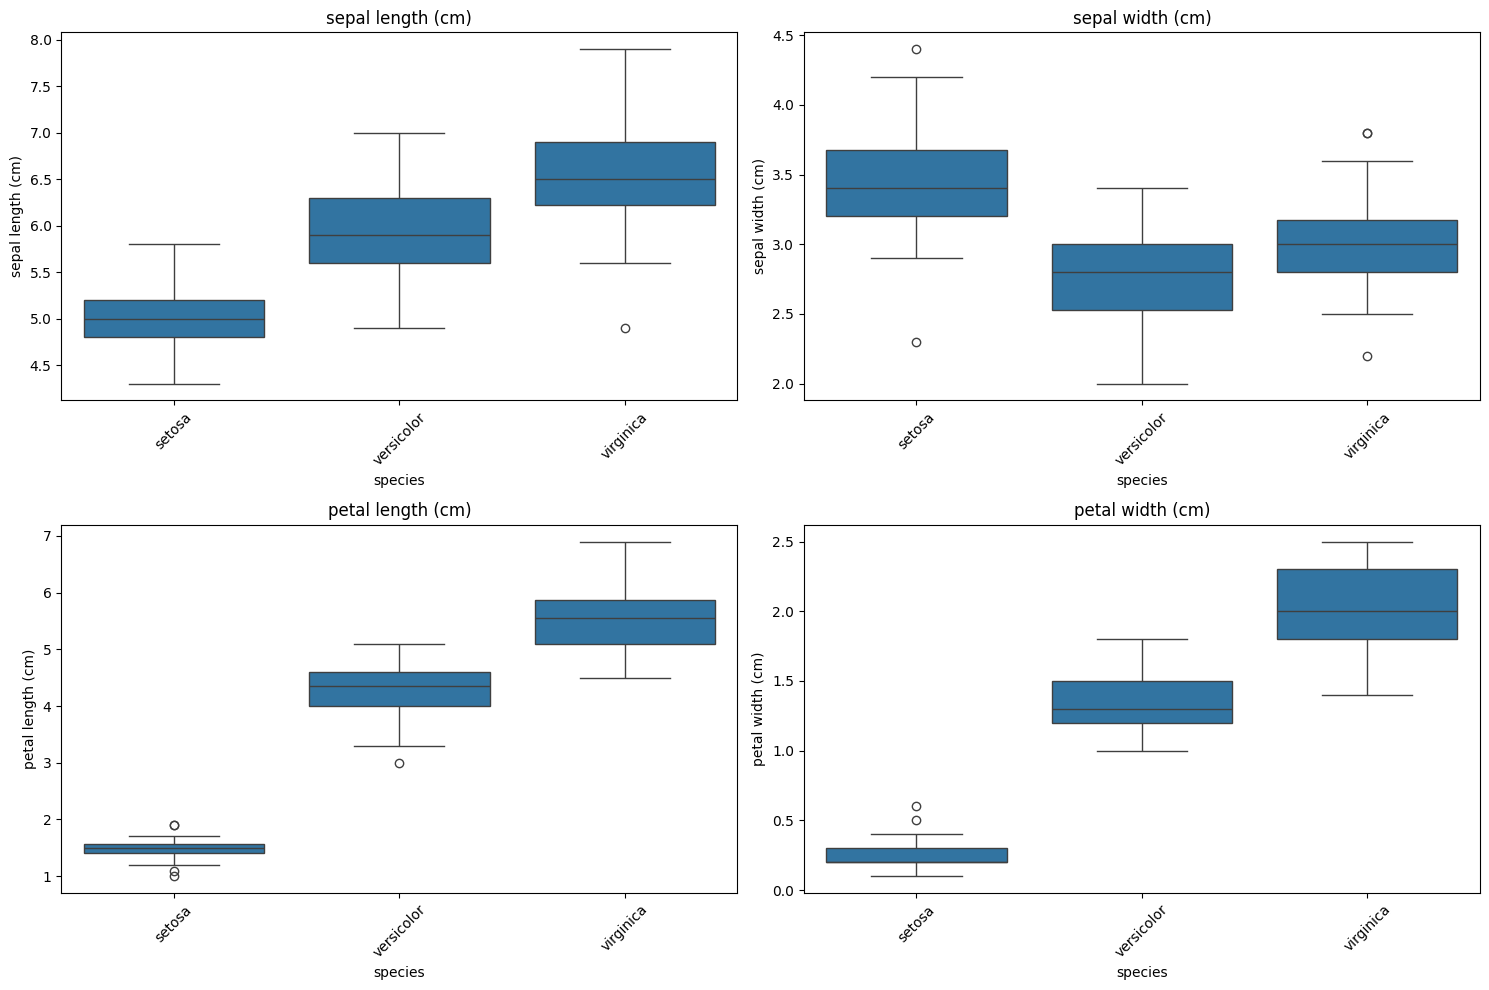

In [8]:
# Boxplots for each feature by species
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for ax, feature in zip(axes, iris.feature_names):
    sns.boxplot(x='species', y=feature, data=df, ax=ax)
    ax.set_title(feature)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

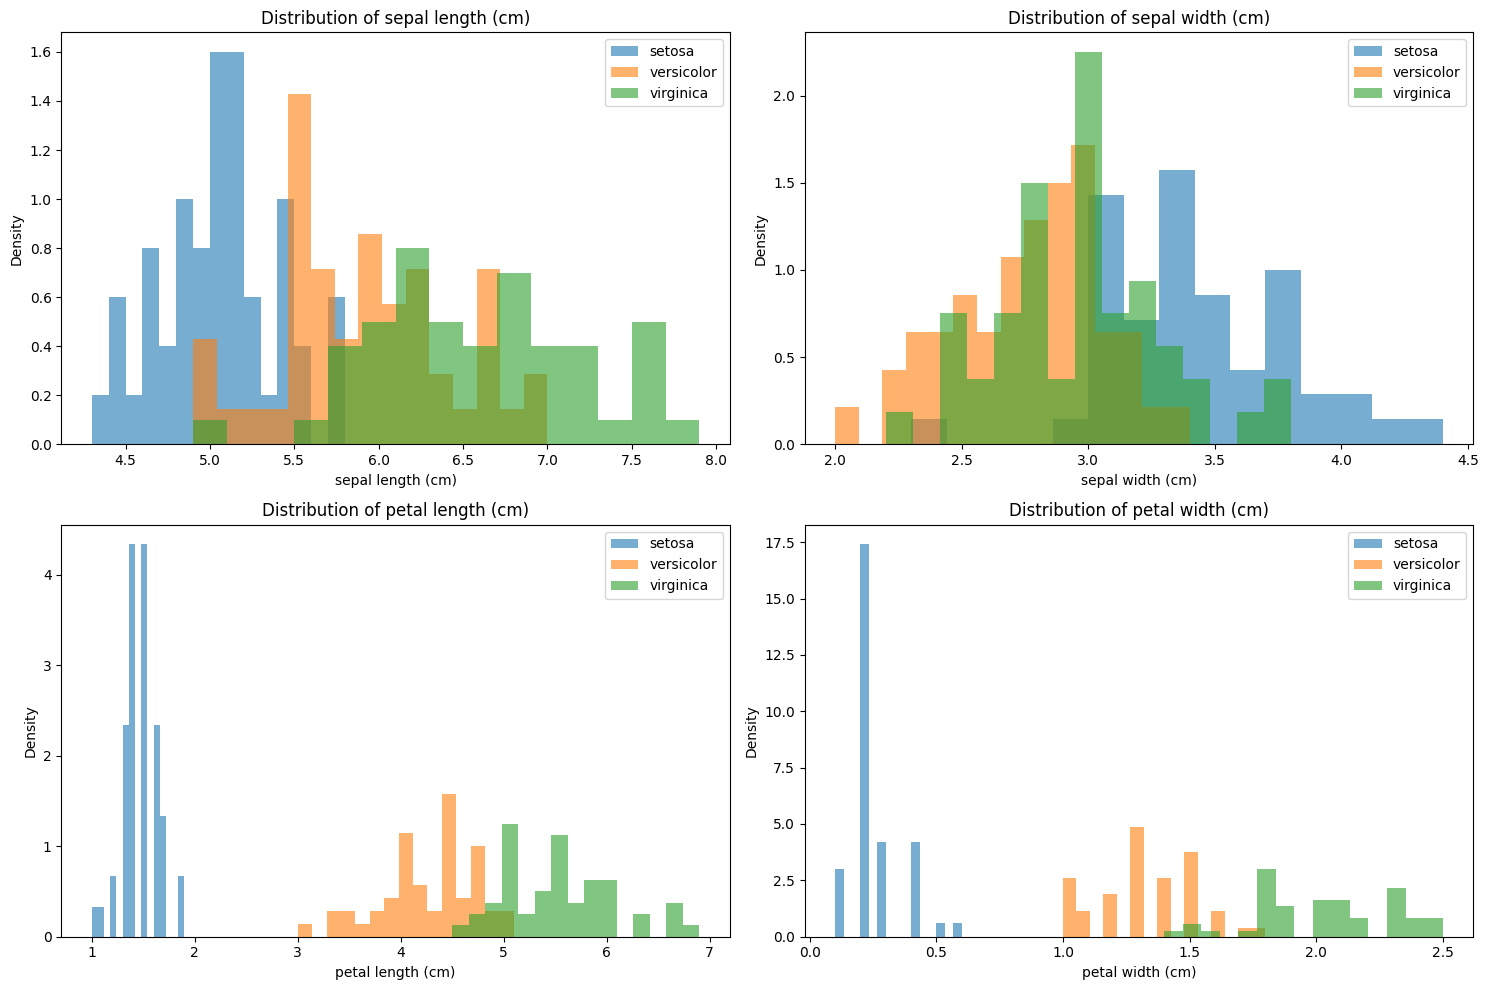

In [9]:
# Distribution plots for each feature
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for ax, feature in zip(axes, iris.feature_names):
    for species in species_names:
        species_data = df[df['species'] == species][feature]
        ax.hist(species_data, alpha=0.6, label=species, bins=15, density=True)
    ax.set_title("Distribution of %s" % feature)
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

### Data Preprocessing

In [10]:
# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### PCA for Dimensionality Reduction and Visualization

In [11]:
# Perform PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("PCA RESULTS:")
print("=" * 50)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance: %.3f" % sum(pca.explained_variance_ratio_))

PCA RESULTS:
Explained variance ratio: [0.72962445 0.22850762]
Total explained variance: 0.958


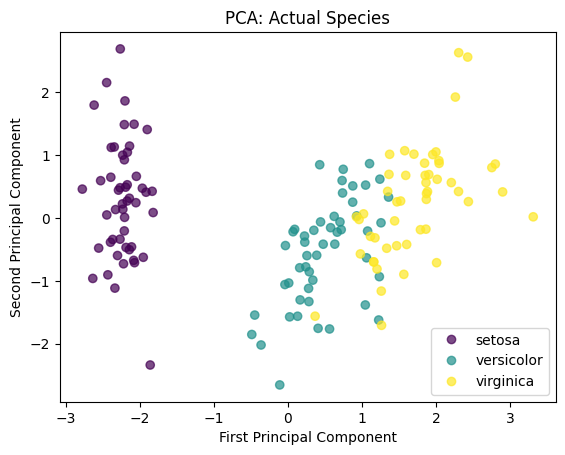

In [12]:
# Visualize PCA results
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=target, cmap='viridis', alpha=0.7)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA: Actual Species')
plt.legend(handles=scatter.legend_elements()[0], labels=species_names.tolist())
plt.show()

### Observation

Based on this visualisation, it is expected that the model will classify setosa with almost 100% accuracy, while struggling with the versicolor/virginica pair.

### Determine Optimal Number of Clusters

In [13]:
# Function to find best label permutation for accuracy
def label_permute_compare(y_true, y_pred):
    """
    y_true: true labels
    y_pred: predicted cluster labels
    Returns:
    - best_perm: best permutation of labels found
    - best_acc: best accuracy achieved
    - best_y_pred_mapped: predicted labels mapped using best permutation
    """
    unique_labels = np.unique(y_pred)
    best_acc = 0.
    
    # Generate all possible permutations of the unique labels
    for perm in permutations(unique_labels):
        # Create mapping from original cluster labels to permuted labels
        y_pred_mapped = [perm[label] for label in y_pred]
        
        accuracy = accuracy_score(y_true, y_pred_mapped)
        if accuracy > best_acc:
            best_acc = accuracy
            best_perm = perm
            best_y_pred_mapped = y_pred_mapped
    
    return best_perm, best_acc, best_y_pred_mapped

In [14]:
# Determine optimal number of clusters using multiple metrics
inertia = []
silhouette_scores_kmeans = []
silhouette_scores_agg = []
accuracy_scores_kmeans = []
accuracy_scores_agg = []
k_range = range(2, 8)

for k in k_range:
    # K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores_kmeans.append(silhouette_score(X_scaled, kmeans_labels))
    accuracy_scores_kmeans.append(label_permute_compare(target, kmeans_labels)[1])
    
    # Agglomerative Clustering
    agg = AgglomerativeClustering(n_clusters=k)
    agg_labels = agg.fit_predict(X_scaled)
    silhouette_scores_agg.append(silhouette_score(X_scaled, agg_labels))
    accuracy_scores_agg.append(label_permute_compare(target, agg_labels)[1])

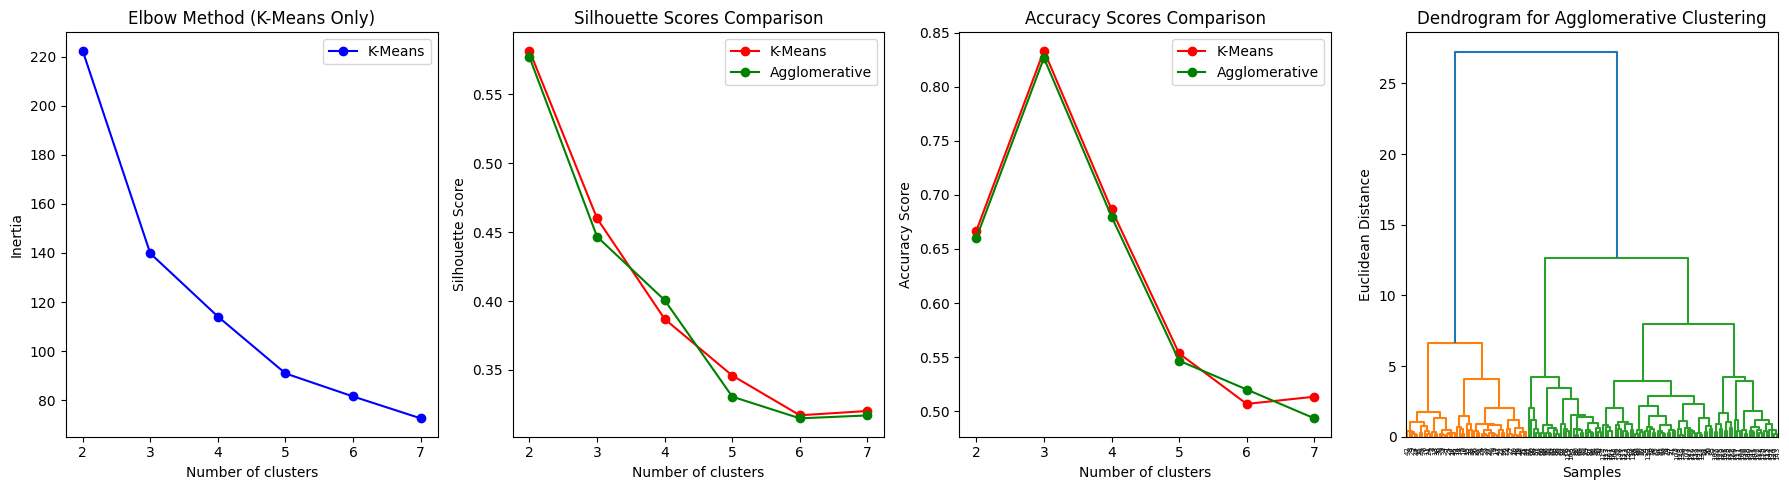

In [15]:
# Plot comparison of methods
plt.figure(figsize=(18, 5))

# Elbow Method
plt.subplot(1, 4, 1)
plt.plot(k_range, inertia, 'bo-', label='K-Means')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method (K-Means Only)')
plt.legend()

# Silhouette Scores Comparison
plt.subplot(1, 4, 2)
plt.plot(k_range, silhouette_scores_kmeans, 'ro-', label='K-Means')
plt.plot(k_range, silhouette_scores_agg, 'go-', label='Agglomerative')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores Comparison')
plt.legend()

# Accuracy Scores Comparison
plt.subplot(1, 4, 3)
plt.plot(k_range, accuracy_scores_kmeans, 'ro-', label='K-Means')
plt.plot(k_range, accuracy_scores_agg, 'go-', label='Agglomerative')
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores Comparison')
plt.legend()

# Dendrogram for Agglomerative Clustering
plt.subplot(1, 4, 4)
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Samples')
plt.ylabel('Euclidean Distance')

plt.tight_layout()
plt.show()

### Apply Both Clustering Algorithms

In [16]:
# Apply both clustering algorithms with optimal clusters (3)
optimal_clusters = 3

# K-Means
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10) # Setting n_init is necessary in this case
kmeans_labels = kmeans.fit_predict(X_scaled)
df['kmeans_cluster'] = kmeans_labels

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=optimal_clusters)
agg_labels = agg.fit_predict(X_scaled)
df['agg_cluster'] = agg_labels

print("K-Means cluster distribution:", np.bincount(kmeans_labels))
print("Agglomerative cluster distribution:", np.bincount(agg_labels))

K-Means cluster distribution: [53 50 47]
Agglomerative cluster distribution: [71 49 30]


### Map Clusters to True Labels for Accuracy Calculation

In [17]:
# Find best label mappings using permutation method
_, kmeans_accuracy, kmeans_mapped = label_permute_compare(target, kmeans_labels)
_, agg_accuracy, agg_mapped = label_permute_compare(target, agg_labels)

# Add mapped labels to dataframe
df['kmeans_mapped'] = kmeans_mapped
df['agg_mapped'] = agg_mapped

print("K-Means accuracy = %.1f%%" % (100 * kmeans_accuracy))
print("Agglomerative accuracy = %.1f%%" % (100 * agg_accuracy))

K-Means accuracy = 83.3%
Agglomerative accuracy = 82.7%


### Calculate Performance Metrics

In [18]:
# Calculate performance metrics
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
agg_silhouette = silhouette_score(X_scaled, agg_labels)

kmeans_ari = adjusted_rand_score(target, kmeans_labels)
agg_ari = adjusted_rand_score(target, agg_labels)

# Create confusion matrices
kmeans_cm = confusion_matrix(target, kmeans_mapped)
agg_cm = confusion_matrix(target, agg_mapped)

# Create comparison table
comparison_df = pd.DataFrame({
    'Algorithm': ['K-Means', 'Agglomerative'],
    'Accuracy': [kmeans_accuracy, agg_accuracy],
    'Silhouette Score': [kmeans_silhouette, agg_silhouette],
    'Adjusted Rand Index': [kmeans_ari, agg_ari],
})

print("PERFORMANCE COMPARISON:")
print("=" * 50)
comparison_df.round(4)

PERFORMANCE COMPARISON:


,Algorithm,Accuracy,Silhouette Score,Adjusted Rand Index
0,K-Means,0.8333,0.4599,0.6201
1,Agglomerative,0.8267,0.4467,0.6153


### Visualize Confusion Matrices

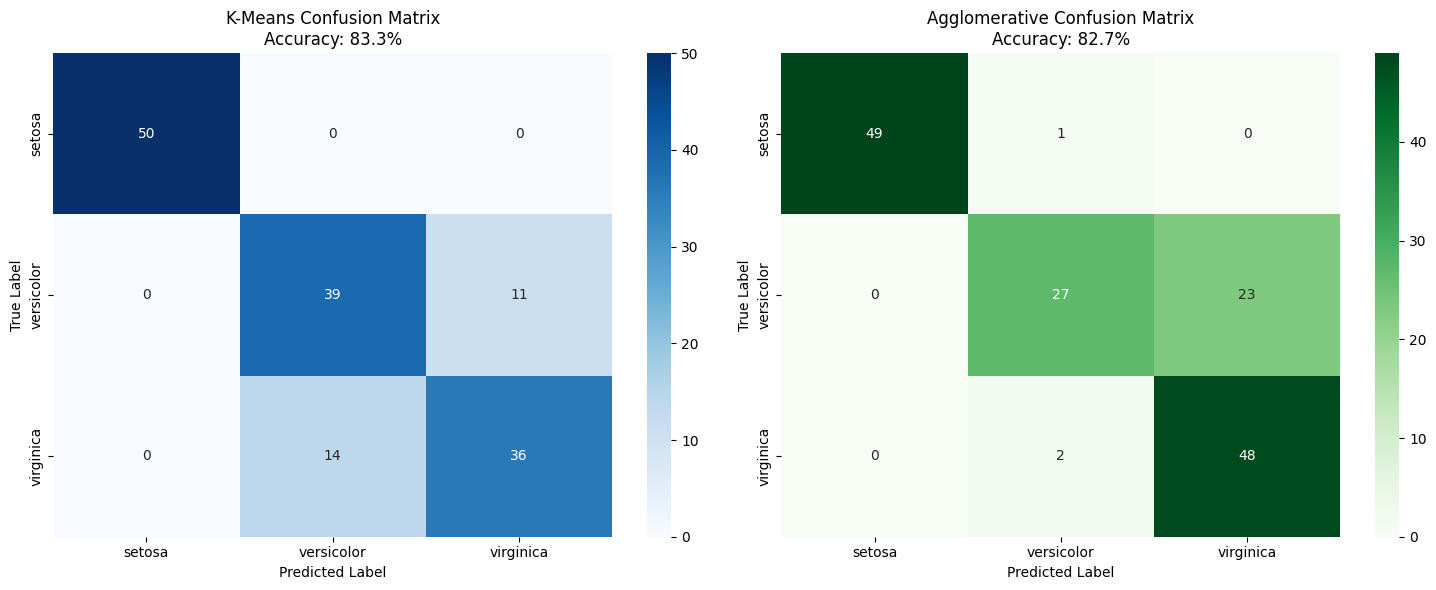

In [19]:
# Plot confusion matrices
plt.figure(figsize=(15, 6))

# K-Means Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(kmeans_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=species_names, yticklabels=species_names)
plt.title('K-Means Confusion Matrix\nAccuracy: %.1f%%' % (100 * kmeans_accuracy))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Agglomerative Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(agg_cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=species_names, yticklabels=species_names)
plt.title('Agglomerative Confusion Matrix\nAccuracy: %.1f%%' % (100 * agg_accuracy))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

### Visualize the Results

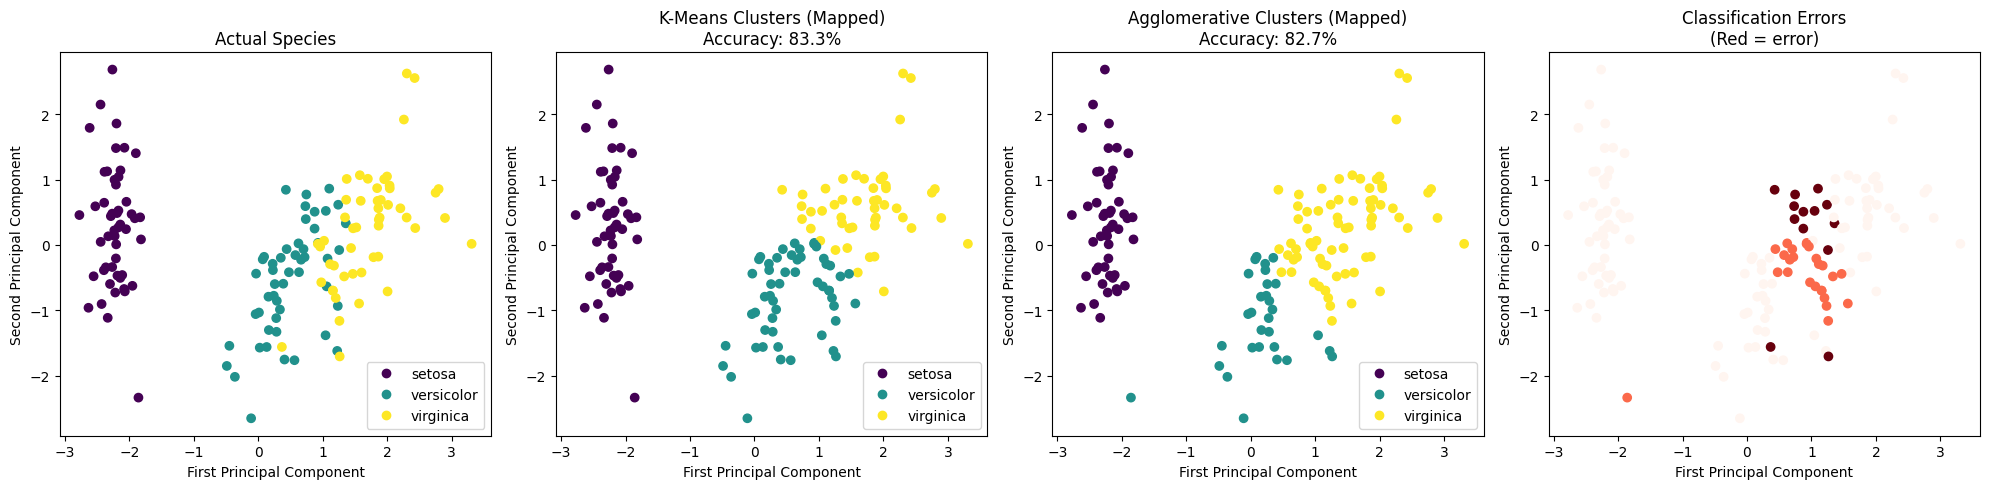

In [20]:
# Create comparison visualization
plt.figure(figsize=(20, 5))

# Actual species
plt.subplot(1, 4, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=target, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Actual Species')
plt.legend(handles=scatter.legend_elements()[0], labels=species_names.tolist())

# K-Means clusters (mapped)
plt.subplot(1, 4, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_mapped, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('K-Means Clusters (Mapped)\nAccuracy: %.1f%%' % (100 * kmeans_accuracy))
plt.legend(handles=scatter.legend_elements()[0], labels=species_names.tolist())

# Agglomerative clusters (mapped)
plt.subplot(1, 4, 3)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_mapped, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Agglomerative Clusters (Mapped)\nAccuracy: %.1f%%' % (100 * agg_accuracy))
plt.legend(handles=scatter.legend_elements()[0], labels=species_names.tolist())

# Error comparison
plt.subplot(1, 4, 4)
kmeans_errors = (target != kmeans_mapped).astype(int)
agg_errors = (target != agg_mapped).astype(int)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_errors + agg_errors, cmap='Reds')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Classification Errors\n(Red = error)')

plt.tight_layout()
plt.show()

### Detailed Error Analysis

In [21]:
# Detailed error analysis
print("DETAILED ERROR ANALYSIS:")
print("=" * 50)

for method, mapped_labels, accuracy in [
    ('K-Means', kmeans_mapped, kmeans_accuracy),
    ('Agglomerative', agg_mapped, agg_accuracy)
]:
    errors = target != mapped_labels
    error_indices = np.where(errors)[0]
    
    print("%s:" % method)
    print("  Total errors: %d / %d (%.1f%%)" % (np.sum(errors), len(errors), np.mean(errors) * 100))
    print("  Accuracy: %.1f%%" % (accuracy * 100))
    
    if len(error_indices) > 0:
        error_samples = df.iloc[error_indices]
        print("  Error breakdown by species:")
        for species in species_names:
            species_errors = error_samples[error_samples['species'] == species]
            total_species = np.sum(target == np.where(species_names == species)[0][0])
            if len(species_errors) > 0:
                print("    %s: %d/%d errors (%.1f%%)" % (species.ljust(10), len(species_errors), total_species, len(species_errors)/total_species*100))

DETAILED ERROR ANALYSIS:
K-Means:
  Total errors: 25 / 150 (16.7%)
  Accuracy: 83.3%
  Error breakdown by species:
    versicolor: 11/50 errors (22.0%)
    virginica : 14/50 errors (28.0%)
Agglomerative:
  Total errors: 26 / 150 (17.3%)
  Accuracy: 82.7%
  Error breakdown by species:
    setosa    : 1/50 errors (2.0%)
    versicolor: 23/50 errors (46.0%)
    virginica : 2/50 errors (4.0%)


## Discussion and Interpretation

Based on all the data above, including the confusion matrices, it seems that Agglomerative clusters confused versicolor as virginica alot, while K-Means confused both equally. In both cases, setosa was classified very accurately, which is expected.

Iris setosa was very easily separated due to its distinct morphological features: a logistic classifier would easily get a 100%.
The other two species are, on the other hand, much more entangled.

Multiple evaluation metrics were used:
- **Accuracy**: Measures direct classification performance
- **Silhouette Score**: Evaluates internal cluster cohesion and separation  
- **Adjusted Rand Index**: Measures similarity between clusterings, adjusted for chance

Both methods scored very similarly on all fronts.

Why is the error so biased towards versicolor though? Looking at the Dendrogram gives us some insight: the items in Agglomerative Clustering are treated as *groups* - as a result, a small deviance of the group of items in the middle to the side of virginica means that the whole group gets misclassified. This could be counted as a disadvantage of the hierarchical scheme of Agglomerative Clustering, suggesting that K-means clustering is more suitable for these types of tasks where K is previously known.

### Practical Implications for botanical research:
- Unsupervised methods can successfully identify species groupings without prior labeling
- Petal measurements are more reliable for species differentiation
- The approach can be extended to other plant classification tasks

### Limitations and Future Work

**Current Limitations:**
- Dataset is relatively small and well-behaved
- Only two clustering algorithms were compared

**Future Directions:**
- Try different linkage methods and distance metrics - these totally change the way the groups are assigned and could fix the skewedness of the Agglomerative Clutering
- Apply to larger, more complex botanical datasets

Note that even if applying different linkage methods and distance metrics solves the issue at hand, the disadvantage of Agglomerative Clustering would still hold, as this would still limit the real practical application of similar scenarios - ones where we know the number of species, but do not know the true labels beforehand.